# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load a DataFrame called `energen_rev` that contains monthly revenue data for the Australian Company Energen from 1961 - 1992. 

This will also load a second `DataFrame` called `test`, that contains the same data over the next 36 months following the time period contained in the `energen_rev` `DataFrame`. 

In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels as sm
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt  
#plt.style.use('dark_background')


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16
!curl https://vcu-scma-440.s3.amazonaws.com/data/energen_rev2.csv > energen_rev2.csv
    
energen_rev = pd.read_csv('energen_rev2.csv', parse_dates=['date']).set_index('date')

N = 36
test = energen_rev[-N:]
energen_rev = energen_rev[:-N]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19864  100 19864    0     0  91119      0 --:--:-- --:--:-- --:--:-- 91119


# Inspecting the data

We have four columns in our `DataFrame`:

* **`revenue`**: Monthly revenue for the Energen company
* **`gas`**: Australian monthly gas production 
* **`elec`**: Australian monthly electricity production 
* **`cars`**: Australian monthly automobile production 

In [16]:
energen_rev.head()

,gas,elec,cars,revenue
date,,,,
1961-07-01,3007,2382,13505.0,2.223052e+06
1961-08-01,2880,2364,14419.0,1.960776e+06
1961-09-01,2490,2129,12877.0,1.807286e+06
1961-10-01,2237,2110,16058.0,1.980928e+06
1961-11-01,2205,2072,19290.0,1.153058e+06


Our aim will be to create a 36 month forecast for the `revenue` variable. To start, let's take a look at a simple plot of the `revenue` over time:

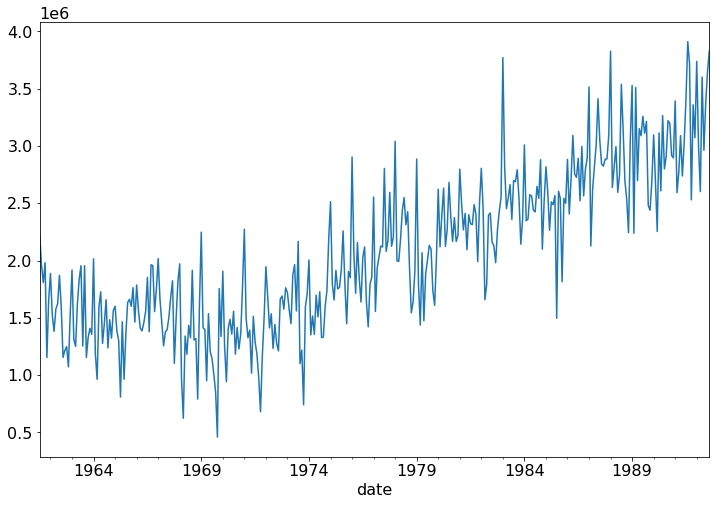

In [17]:
energen_rev['revenue'].plot()

We can also plot the time series of our independent variables over time. 

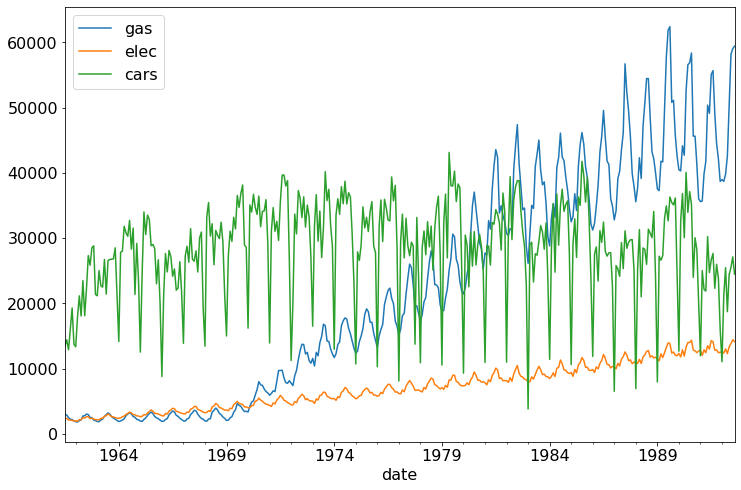

In [18]:
energen_rev[['gas','elec','cars']].plot()

As we've done before, we can plot scatter matrices and calculate correlations between our variables using `pd.plotting.scatter_matrix()` and `energen_rev.corr()`. Do this in the cell below and display the results. 

,gas,elec,cars,revenue
gas,1.000000,0.975486,0.134027,0.822151
elec,0.975486,1.000000,0.120572,0.820370
cars,0.134027,0.120572,1.000000,-0.332364
revenue,0.822151,0.820370,-0.332364,1.000000


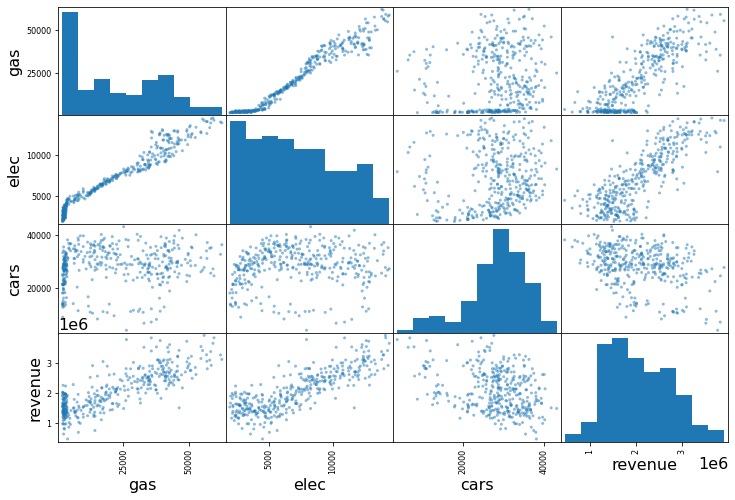

In [19]:
# YOUR CODE HERE

my_figure = pd.plotting.scatter_matrix(energen_rev)

display(energen_rev.corr())

To use multiple linear regression to create a 36 month forecast for this data, we'll have to complete the following steps:

1. Fit a regression model of the form `revenue ~ gas + elec + cars`
2. Use an appropriate exponential smoothing forecasting technique to create 36 month forecasts for our _independent_ variables
3. Use forecasts of independent variables to forecast the _dependent_ variable with the regression model from 1)

We'll walk through each of these steps below

# Fitting a Regression Model

We seek to fit a regression model of the form `revenue ~ gas + elec + cars`. In the cell below, do this and print out the model summary. For

In [20]:
# YOUR CODE HERE
#regression_model = # YOUR CODE HERE
#regression_results = # YOUR CODE HERE
#display(regression_results.summary())

##################
# 
# SOLUTION
# 
##################

# Fit a basic linear model
regression_model = ols('revenue ~ gas + elec + cars', energen_rev)
regression_results = regression_model.fit()
display(regression_results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     898.5
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.87e-169
Time:                        22:04:23   Log-Likelihood:                -5161.9
No. Observations:                 374   AIC:                         1.033e+04
Df Residuals:                     370   BIC:                         1.035e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.311e+06   7.11e+04     32.521      0.000    2.17e+06    2.45e+06
gas           24.1589      3.293      7.336      0.000      17.683      30.635
elec          57.5212     16.560      3.473      0.001      24.957      90.085
cars         -42.0429      1.713    -24.537      0.000     -45.412     -38.674
==============================================================================
Omnibus:                        0.342   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.351
Skew:                          -0.073   Prob(JB):                        0.839
Kurtosis:                       2.963   Cond. No.                     2.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As before, we can access the fitted values from `model_results.fittedvalues`, add them as an additional column in our `DataFrame` and plot the fit:

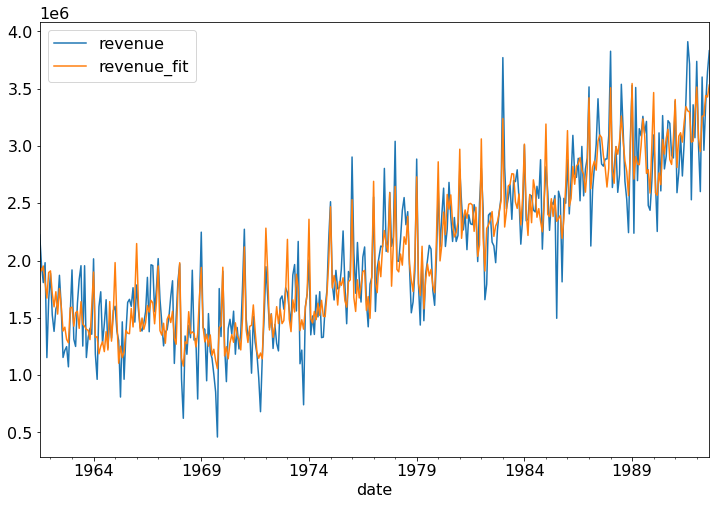

In [21]:
fitted_values = regression_results.fittedvalues
energen_rev['revenue_fit'] = fitted_values

energen_rev[['revenue','revenue_fit']].plot()

# Forecasting Independent Variables

In order to generate a 36 month forecast beyond the window of our existing data, we'll need to forecast out 36 months of our _independent_ variables. As observed above, each of the independent variables exhibit some periodic fluctuations, which may indicate seasonality. Because of this, we'll use Holt-Winter's exponential smoothing to forecast. 

We'll begin with the `gas` data. The trend appears to be (roughly) linearly increasing with time, while the amplitude of the periodic fluctuations seems to be increasing over time, so we'll use an _additive_ trend component and a _multiplicative_ seasonal. Additionally, we'll specify that the data have 12 periods per seasonal cycle (monthly data). 

Lastly, when we call `gas_model.fit()`, we won't specify any values for our smoothing parameters, letting the `model.fit()` function determine the optimized values for these parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


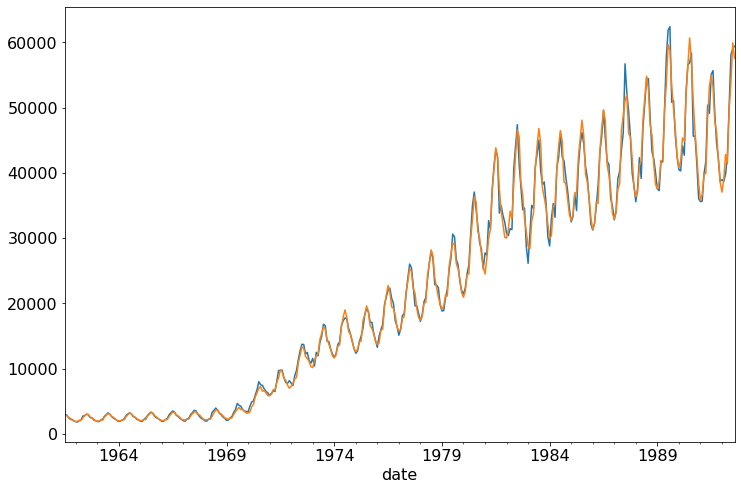

In [22]:
gas_model = ExponentialSmoothing(
    energen_rev['gas'], 
    seasonal='mul', 
    seasonal_periods=12, 
    trend='add'
)
gas_results = gas_model.fit()

energen_rev['gas_fit'] = gas_results.fittedvalues
energen_rev['gas'].plot()
energen_rev['gas_fit'].plot()

The `cars` time series appears to be roughly stationary, so we'll not specify any specifics about the form of the components. The only thing that we'll specify is the value for the `smoothing_level`. We'll specify a rather high value of `0.9` to allow the model to react quickly to the fluctuations the time series. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Dep. Variable:,endog,No. Observations:,374
Model:,ExponentialSmoothing,SSE,21546285834.229
Optimized:,True,AIC,6687.086
Trend:,None,BIC,6694.934
Seasonal:,None,AICC,6687.194
Seasonal Periods:,None,Date:,"Mon, 29 Mar 2021"
Box-Cox:,False,Time:,22:04:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
initial_level,13510.000,l.0,True


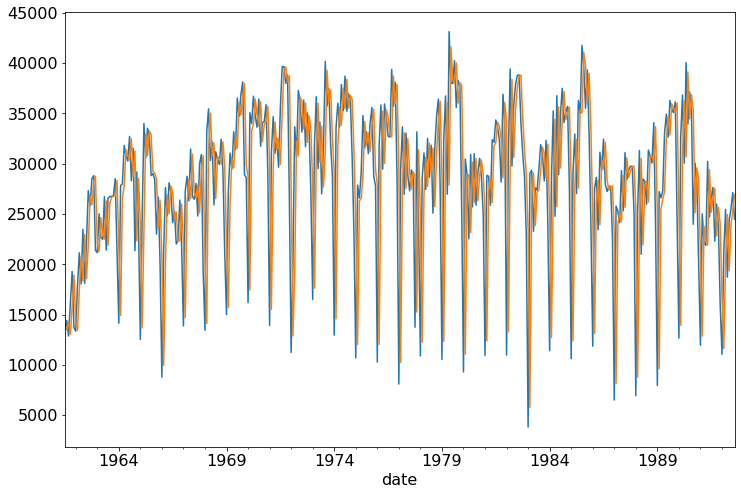

In [23]:
cars_model = ExponentialSmoothing(
    energen_rev['cars']
)

cars_results = cars_model.fit(smoothing_level=0.9)

energen_rev['cars_fit'] = cars_results.fittedvalues
energen_rev['cars'].plot()
energen_rev['cars_fit'].plot()

display(cars_results.summary())

This appears to provide a good fit to the observed data. 

As the `elec` series exhibits very similar behavior to the `gas` series, create an `ExponentialSmoothing` model for the elec series using the exact same parameters as we did for the `gas` series above, but changing the model name from `gas_model` to `elec_model`, and `gas_results` to `elec_results`. 

After that, plot the fitted values for the `elec` series just as for the `gas` above.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Dep. Variable:,endog,No. Observations:,374
Model:,ExponentialSmoothing,SSE,10778226.456
Optimized:,True,AIC,3872.525
Trend:,Additive,BIC,3935.313
Seasonal:,Multiplicative,AICC,3874.452
Seasonal Periods:,12,Date:,"Mon, 29 Mar 2021"
Box-Cox:,False,Time:,22:04:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2105263,alpha,True
smoothing_slope,0.0526316,beta,True


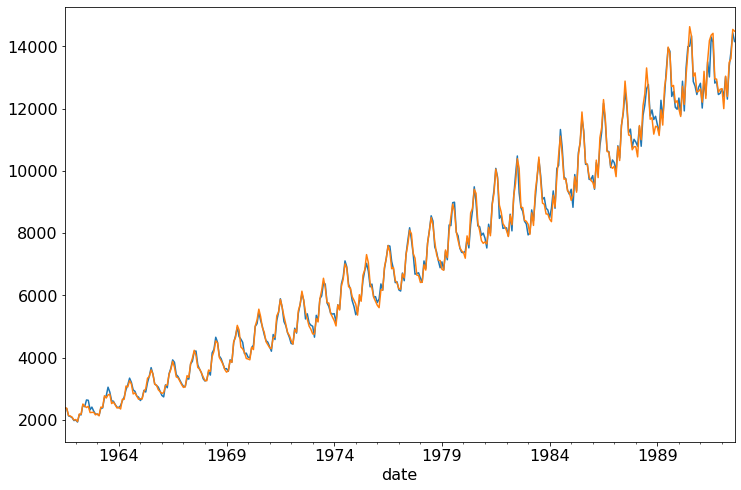

In [24]:
# YOUR CODE HERE

# elec_model = ...
#elec_results = ...

##############################
#
# Solution
#
##############################

elec_model = ExponentialSmoothing(
    energen_rev['elec'], 
    seasonal='mul', 
    seasonal_periods=12, 
    trend='add'
)

elec_results = elec_model.fit()

energen_rev['elec_fit'] = elec_results.fittedvalues
energen_rev['elec'].plot()
energen_rev['elec_fit'].plot()
display(elec_results.summary())

# Creating Smoothed Forcasts for Independent Variables

We next need to create smoothed forecasts for our independent variables. We can do this using the `model.predict()` function, feeding in `model.params` as the first argument, followed by the start and end indices for the time period over which we'd like to predict. In the cell below, this is carried out for the `gas` series:

In [25]:
# Forecast for N months out
N_months = 36

# Start of window for our prediction
start = energen_rev.shape[0]
# End of window for our prediction
end = energen_rev.shape[0] + N - 1

gas_predictions = gas_model.predict(gas_model.params, start, end)

In the cell below, create two new series (`elec_predictions` and `cars_predictions`) that contain the 36 month predictions for the `elec` and `cars` series respectively (this should be a single line in the cell for each variable, similar to the last line in the cell above. 

In [26]:
# YOUR CODE HERE

# elec_predictions = ...
# cars_predictions = ...

##############################
#
# Solution
#
##############################

elec_predictions = elec_model.predict(elec_model.params, start, end)
cars_predictions = cars_model.predict(cars_model.params, start, end)

The last thing that we need to do before we can forecast with our regression model is to put the forecast values of our independent variables in the format that our regression model is expecting, i.e. a `DataFrame` with the four columns: `Intercept`, `gas`, `elec`, and `cars`. This is done in the cell below:

In [27]:
indep_predictions = pd.DataFrame(index=test.index)

indep_predictions['Intercept'] = [1.0] * N_months
indep_predictions['gas'] = gas_predictions
indep_predictions['elec'] = elec_predictions
indep_predictions['cars'] = cars_predictions

indep_predictions.head()

,Intercept,gas,elec,cars
date,,,,
1992-09-01,1.0,51495.409436,13056.337666,24720.700179
1992-10-01,1.0,49168.557885,13094.055183,24720.700179
1992-11-01,1.0,45494.690986,12685.747084,24720.700179
1992-12-01,1.0,41713.813624,12771.328010,24720.700179
1993-01-01,1.0,40014.936783,12866.605753,24720.700179


# Forecasting with Our Regression Model

The last thing that we want to do is to create a forecast with our regression model. To do this, we'll use the `regression_model.predict()` function, feeding in `regression_results.params` as the first argument, and the `DataFrame` of forecast values for the _independent_ variables as the second argument. 

This is carried out in the cell below, and the resulting forecast values plotted:

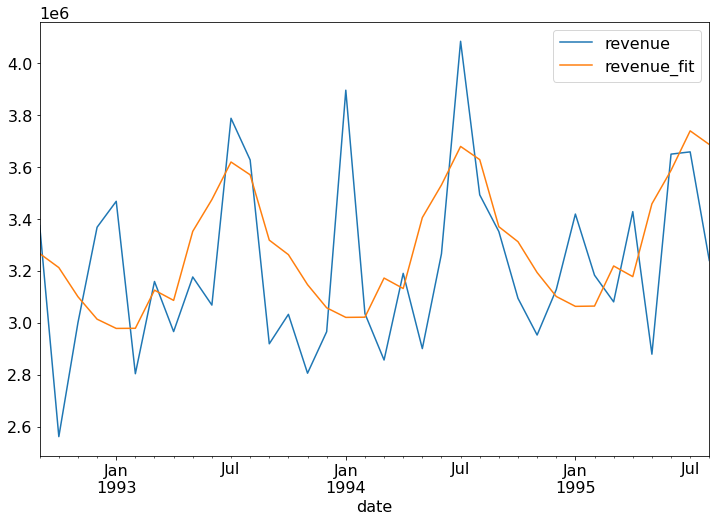

In [28]:
fitted_values = regression_model.predict(regression_results.params, indep_predictions)
test['revenue_fit'] = fitted_values

test[['revenue','revenue_fit']].plot()